### DCGAN for faces :

#### Importing libraries :

In [1]:
url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
filename = "lfw.tgz"
directory = "imgs"
new_dir = "new_imgs"
import urllib.request
import tarfile
import urllib
import os

from glob import glob
import imageio
import glob
import cv2

from tqdm import tqdm
from PIL import Image
import PIL

import matplotlib.pyplot as plt
from datetime import datetime
from IPython import display

from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, GlobalAveragePooling2D, ReLU
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from numpy import expand_dims, zeros, ones
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf
import numpy as np

from warnings import filterwarnings
filterwarnings('ignore')

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction=.23

filter_size = 5

#### Data handling :

In [0]:
def crop_face(dataPath, savePath, target_size, cascPath='haarcascade_frontalface_default.xml'):
    # find a face in image and crop it
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascPath)

    count = 0

    # Read the image
    for fn in tqdm(dataPath):
        if fn[-4:] == '.jpg':
            image = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            faces = faceCascade.detectMultiScale(gray, 5, 5)

            if len(faces) != 1:
                pass
            else:
                x, y, w, h = faces[0]
                image_crop = image[y: y+w, x : x+w, :]
                image_resize = cv2.resize(image_crop, target_size)
                savePath.append(image_resize)
                count+=1
        else:
            pass

    print("total: %d / %d" % (count, len(dataPath)))

In [0]:
if not os.path.isdir(directory):
    if not os.path.isfile(filename):
        urllib.request.urlretrieve (url, filename)
    tar = tarfile.open(filename, "r:gz")
    tar.extractall(path=directory)
    tar.close()

filepaths = []
for dir_, _, files in os.walk(directory):
    for fileName in files:
        relDir = os.path.relpath(dir_, directory)
        relFile = os.path.join(relDir, fileName)
        filepaths.append(directory + "/" + relFile)

In [4]:
dataset = []

crop_face(filepaths, dataset, (64, 64))

# for fp in tqdm(filepaths):
#   image = Image.open(fp)
#   image = image.convert('RGB')
#   image = image.resize((64, 64), Image.ANTIALIAS)
#   dataset.append(np.array(image))

dataset = np.array(dataset)
dataset = (dataset.astype('float32')-127.5)/127.5

dataset.shape

100%|██████████| 13233/13233 [01:11<00:00, 185.24it/s]


total: 11409 / 13233


(11409, 64, 64, 3)

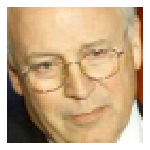

In [5]:
plt.figure(figsize=(2.5,2.5))
plt.imshow((dataset[35]+1)/2.0)
plt.axis('off')
plt.show()

#### Util funcs :

In [0]:
!mkdir ./FakeFaces/

def save_plot(examples, epoch, n=5):
  plt.figure(figsize=(6, 6))
  examples = (examples + 1) / 2.0
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i])
  filename = './FakeFaces/generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.show()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, seed, n_samples=25):
	
	X_real, y_real = generate_real_samples(dataset, n_samples)
	
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples, seed)
	
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	
	save_plot(x_fake, epoch)

	# filename = 'generator_model_%03d.h5' % (epoch+1)
	# g_model.save(filename)

def generate_real_samples(dataset, n_samples, offset=None):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix] # dataset[offset*n_samples:(offset+1)*n_samples] if offset is not None else dataset[ix]
	y = ones((n_samples, 1))
	return X, y

def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(g_model, latent_dim, n_samples, seed=None):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(seed if seed is not None else x_input)
	y = zeros((n_samples, 1))
	return X, y

def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

#### Models :

##### Generator :

In [0]:
filter_size = 5
alpha = 0.2

In [0]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	
	# foundation for 4x4 image
	n_nodes = 64 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim, use_bias=False)); model.add(BatchNormalization());
	model.add(LeakyReLU(alpha=0.2))
  
	# Reshaping
	model.add(Reshape((8, 8, 64)))
	print(model.output_shape)
  
	# upsample
	model.add(Conv2DTranspose(64, filter_size, strides=(2,2), padding='same',\
	                          use_bias=False)); model.add(BatchNormalization());
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
  
	# upsample
	model.add(Conv2DTranspose(128, filter_size, strides=(2,2), padding='same',\
	                          use_bias=False)); model.add(BatchNormalization());
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
  
	# upsample
	model.add(Conv2DTranspose(128, filter_size, strides=(2,2), padding='same',\
	                          use_bias=False)); # model.add(BatchNormalization());
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
  
	# output layer
	model.add(Conv2D(3, filter_size, activation='tanh', padding='same',\
	                 use_bias=False)); print(model.output_shape)
	return model

##### Discriminator :

In [0]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	print(in_shape)
	model = Sequential()
	# normal
	model.add(Conv2D(128, (5,5), padding='same',input_shape=in_shape, use_bias=False))
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
  
	# downsample
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same',\
	                 use_bias=False)); model.add(BatchNormalization());
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
  
	# downsample
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same',\
	                 use_bias=False)); model.add(BatchNormalization());
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
  
	# downsample
	model.add(Conv2D(256, (5,5),  strides=(2,2), padding='same',\
	                 use_bias=False)); model.add(BatchNormalization());
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
	
	# classifier
	model.add(Flatten())
	# model.add(GlobalAveragePooling2D())
	
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid', use_bias=False))
	
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	
	return model

##### Combined :

In [15]:
# size of the latent space
latent_dim = 100

print('Discriminator')
d_model = define_discriminator(in_shape=(64, 64, 3))

print('Generator')
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

Discriminator
(64, 64, 3)
(None, 64, 64, 128)
(None, 32, 32, 128)
(None, 16, 16, 128)
(None, 8, 8, 256)
Generator
(None, 8, 8, 64)
(None, 16, 16, 64)
(None, 32, 32, 128)
(None, 64, 64, 128)
(None, 64, 64, 3)


In [0]:
flip_pts_percent = .1

def train(g_model, d_model, gan_model, dataset, latent_dim, seed, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  
  for i in range(n_epochs):
    start=datetime.now()
    for j in range(bat_per_epo):
      # ======================== Train discrimintor on real images ========================= #
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # y_real = np.round(np.random.uniform(.8, 1.2, (half_batch, 1)), 1) # Label Smoothing
      y_real *= .9

      # Label Flipping
      idxs = np.random.randint(0, y_real.shape[0], int(flip_pts_percent*half_batch))
      y_real[idxs] = .2 # np.round(np.random.uniform(.1, .3, (int(flip_pts_percent*half_batch), 1)))
      
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # ======================== Train discrimintor on real images ========================= #

      
      # ======================== Train discrimintor on fake images ========================= #
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      
      # Label Flipping
      # idxs = np.random.randint(0, y_real.shape[0], int(flip_pts_percent*half_batch))
      # y_fake[idxs] = 1 - y_fake[idxs]
      
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # ======================== Train discrimintor on fake images ========================= #
      
      
      # ======================== Train generator on latent points ========================= #
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      
      if not j%10:
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

    display.clear_output(True)
    print('Time for epoch {} :'.format(i+1),datetime.now()-start)
    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    summarize_performance(i, g_model, d_model, dataset, latent_dim, seed, 25)
  
  display.clear_output(True)
  print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  summarize_performance(i, g_model, d_model, dataset, latent_dim, seed, 25)

#### Training :

>100, 178/178, d1=0.510, d2=0.044 g=0.839
>Accuracy real: 52%, fake: 88%


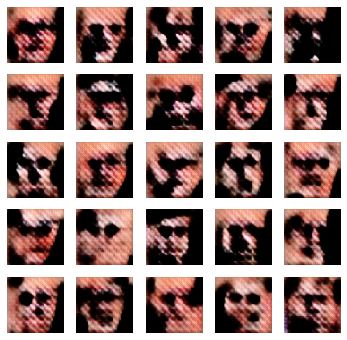

In [17]:
x_noise = generate_latent_points(latent_dim, 25)

# Train model
train(g_model, d_model, gan_model, dataset, latent_dim, x_noise, 100, n_batch=64)

>100, 206/206, d1=0.504, d2=0.538 g=2.093
>Accuracy real: 80%, fake: 84%


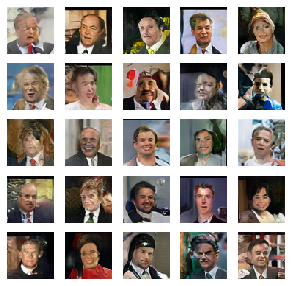

In [13]:
train(g_model, d_model, gan_model, X, latent_dim, x_noise, 100, n_batch=64)

>100, 178/178, d1=0.723, d2=0.405 g=1.825
>Accuracy real: 64%, fake: 76%


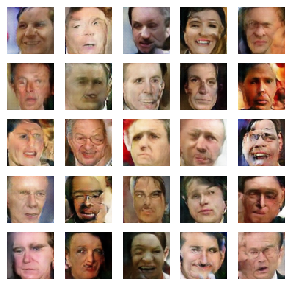

In [0]:
x_noise = generate_latent_points(latent_dim, 25)

# Train model
train(g_model, d_model, gan_model, X, latent_dim, x_noise, 100, n_batch=64)

In [0]:
from tensorflow.keras.models import save_model, load_model

def saveModels(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, 'gan.h5')
    discriminator.trainable = True
    save_model(generator, 'generator.h5')
    save_model(discriminator, 'discriminator.h5')


def loadModels():
    discriminator = load_model('discriminator.h5')
    generator = load_model('generator.h5')
    gan = load_model('gan.h5')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [0]:
saveModels(gan_model, g_model, d_model)

#### Generating Images :

In [0]:
pred = g_model.predict(np.random.normal(size=[25, 100]))
pred = (pred+1)/2.0

f, a = plt.subplots(5,5, figsize=(6,6))
a = a.flatten()

for a, pic in zip(a, pred):
  a.imshow(pic)
  a.axis('off')

plt.show()

In [0]:
import glob

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('FakeSamples/generated_plot_e*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [0]:
display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

### DCGAN for Flowers

In [0]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

def save_plot(examples, epoch, n=3):
  plt.figure(figsize=(4, 4))
  examples = (examples + 1) / 2.0
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i])
  filename = './FakeSamples/generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.show()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, seed, n_samples=9):
	
	X_real, y_real = generate_real_samples(dataset, n_samples)
	
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples, seed)
	
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	
	save_plot(x_fake, epoch)

	# filename = 'generator_model_%03d.h5' % (epoch+1)
	# g_model.save(filename)

def generate_real_samples(dataset, n_samples, offset=None):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y

def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(g_model, latent_dim, n_samples, seed=None):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(seed if seed is not None else x_input)
	y = zeros((n_samples, 1))
	return X, y

def train(g_model, d_model, gan_model, dataset, latent_dim, seed, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real * .9)

      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      
      if not j%10:
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

    display.clear_output(True)
    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    summarize_performance(i, g_model, d_model, dataset, latent_dim, seed)
  
  display.clear_output(True)
  print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  summarize_performance(i, g_model, d_model, dataset, latent_dim, seed)

In [0]:
!rm ./FakeSamples/*

In [28]:
!mkdir ./FakeSamples

mkdir: cannot create directory ‘./FakeSamples’: File exists


In [33]:
from google.colab import drive
drive.mount('/content/drive')

# load and prepare Flowers training images
def load_real_samples():
  x = np.load('drive/My Drive/Datasets/FlowerData.npy').astype('float32')
  x = (x - 127.5) / 127.5
  return x

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim)); # model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 256)))
	print(model.output_shape)
	
	# upsample
	model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same')); model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
	
	# upsample
	model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same')); model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
	
	# upsample
	model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same')); model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
	
	# output layer
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	print(model.output_shape)
 
	return model

In [0]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (5,5), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
  
	# downsample
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same')); model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
  
	# downsample
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same')); model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
	
	# downsample
	model.add(Conv2D(256, (5,5), strides=(2,2), padding='same')); model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	print(model.output_shape)
  
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	
	print(model.output_shape)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [0]:
dataset = load_real_samples()

In [75]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model_flower = define_discriminator(in_shape=(64, 64, 3))
# create the generator
g_model_flower = define_generator(latent_dim)
# create the gan
gan_model_flower = define_gan(g_model_flower, d_model_flower)

(None, 64, 64, 64)
(None, 32, 32, 128)
(None, 16, 16, 128)
(None, 8, 8, 256)


In [71]:
g_model_flower.output_shape, d_model_flower.output_shape

((None, 64, 64, 3), (None, 1))

>150, 134/134, d1=0.535, d2=0.125 g=2.863
>Accuracy real: 100%, fake: 78%


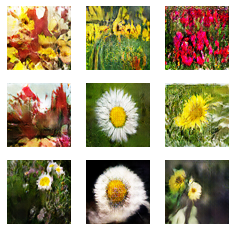

In [85]:
seed = generate_latent_points(latent_dim, 9)
# train model
train(g_model_flower, d_model_flower, gan_model_flower, dataset, latent_dim, seed, 150, n_batch=32)

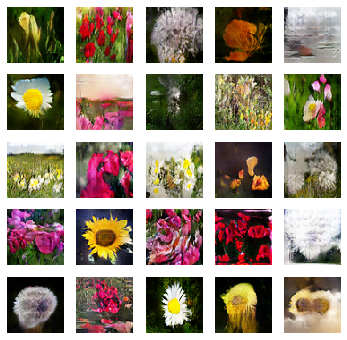

In [86]:
pred = g_model_flower.predict(np.random.normal(size=[25, latent_dim]))
pred = (pred+1)/2.0

f, a = plt.subplots(5,5, figsize=(6,6))
a = a.flatten()

for a, pic in zip(a, pred):
  a.imshow(pic,)
  a.axis('off')

plt.show() 

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('FakeSamples/generated_plot_e*.png')
  filenames = sorted(filenames)
  # filenames = filenames[:-30]
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [0]:
# import IPython
# if IPython.version_info > (6,2,0,''):
display.Image(filename=anim_file)

In [0]:
from tensorflow.keras.models import save_model, load_model

def saveModels(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, 'gan.h5')
    discriminator.trainable = True
    save_model(generator, 'generator.h5')
    save_model(discriminator, 'discriminator.h5')


def loadModels():
    discriminator = load_model('discriminator.h5')
    generator = load_model('generator.h5')
    gan = load_model('gan.h5')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [0]:
saveModels(gan_model_flower, g_model_flower, d_model_flower)

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('generator.h5')
  files.download('gan.h5')
  files.download('discriminator.h5')